# USAD

### USAD : UnSupervised Anomaly Detection on Multivariate Time Series¶

In [9]:
from IPython.display import Image

USAD - быстрый и стабильный
метод, называемый неконтролируемым обнаружением аномалий для многомерных
временных рядов, основанный на плохо обученных автокодерах. Его
Архитектура автоэнкодера делает его способным к обучению неожиданным способом. Использование состязательного обучения и его архитектуры
позволяет изолировать аномалии, обеспечивая при этом быстрое обучение. 

Мониторинг ИТ-системы - это процесс наблюдения за измеримыми событиями
и выходными данными системы, который используется в качестве эталона, определяющего
надлежащее функционирование системы. Отклонения от эталона
анализируются, чтобы определить, существует ли неисправность. Исторически этот
анализ проводился экспертами по системному мониторингу, которые устанавливают
пороговые значения нормального поведения для каждого измеренного события/выходного сигнала. Если
измерение превышает соответствующий порог, определенный экспертом
, считается, что система ведет себя не так, как ожидалось. Потому что
учитывая масштабы и сложность современных ИТ-операций,
количество датчиков, необходимых для получения измерений с течением времени
, резко возросло, что делает традиционные методы, основанные на пороговых значениях, определяемых экспертами, более непригодными, поскольку они не масштабируются. При
таком сценарии автоматизация мониторинга нашей ИТ-системы
стала необходимостью. Автоматизированный мониторинг ИТ-систем потребовал
разработки методов, которые отслеживают различные измерения
, полученные датчиками, и на их основе делают вывод о нормальном и ненормальном
поведении.


Наиболее часто используемые методы включают методы, основанные на расстоянии
, такие как k-ближайшие соседи, кластеризация, такая как K-средние, классификация с помощью одноклассового SVM. Однако современные ИТ-системы
достигли такой сложности, что больше не позволяют использовать эти
методы. Действительно, по мере увеличения числа измерений эти технологии, как правило, страдают от неоптимальной производительности из-за
проклятия размерности. Совсем недавно
большое внимание привлекла способность неконтролируемых методов обнаружения аномалий, основанных на глубоком обучении, определять корреляционные связи между временными рядами, которые позволяют идентифицировать аномальное
поведение


Среди методов глубокого обучения для обнаружения аномалий на временных данных методы, основанные на рекуррентных нейронных сетях (RNNs)
пользуются большой популярностью. Однако результаты RNNs хорошо известны тем, что они требуют больших вычислительных затрат и требуют значительного количества
времени для подготовки. Таким образом, RNN несут высокие затраты, связанные со временем, потребление энергии и выбросы CO2.


Предлагаемый нами метод обнаружения неконтролируемых аномалий (USAD) сформулирован как архитектура AE в рамках двухфазной системы дополнительного обучения. С одной стороны, это позволяет преодолеть
внутренние ограничения AEs путем обучения модели, способной идентифицировать, когда входные данные не содержат аномалии, и, таким образом,
проведите хорошую реконструкцию. С другой стороны, архитектура AE позволяет добиться стабильности во время состязательного обучения, тем
самым решая проблему коллапса и режима несходимости
, с которыми сталкиваются в GANs.
USAD состоит из трех элементов: сети кодирования E
и двух сетей декодирования D1 и D2. Как показано на рисунке 1,
три элемента соединены в архитектуру, состоящую из двух
автокодеров AE1 и AE2, совместно использующих одну и ту же сеть кодирования.:
AE1(W ) = D1(E(W )), AE2(W ) = D2(E(W )) (3)
Архитектура из Eq. 3 обучается в два этапа. Во-первых,
два AE обучаются тому, чтобы научиться восстанавливать нормальные входные значения W . Во-вторых, два AE обучаются состязательным образом,
где AE1 будет стремиться обмануть AE2, а AE2 стремится узнать,
являются ли данные реальными (поступающими непосредственно от W) или реконструированными (поступающими
от AE1).

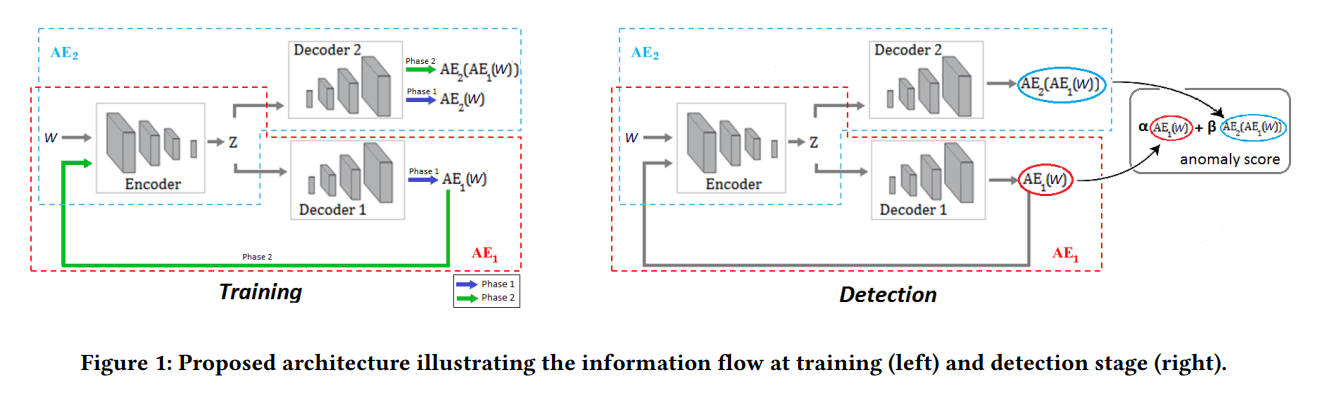

In [10]:
Image('./Data/USAD_a1_pic1.png')

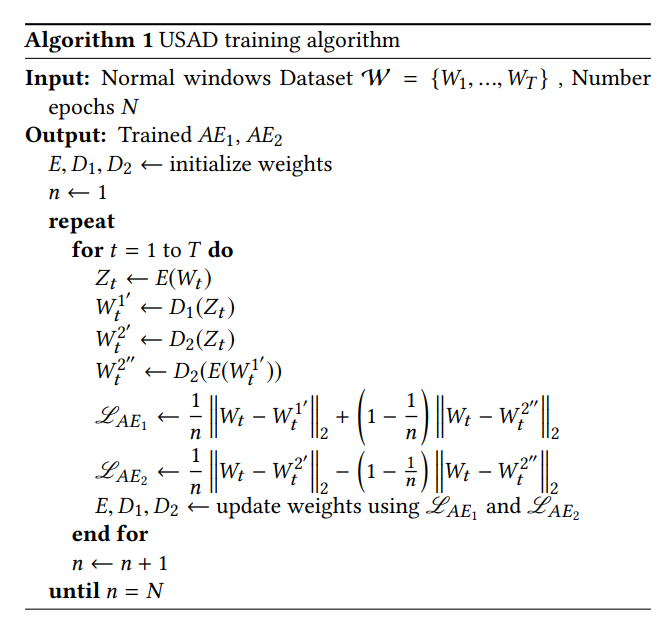

In [11]:
Image('./Data/USAD_a1_pic2.png')

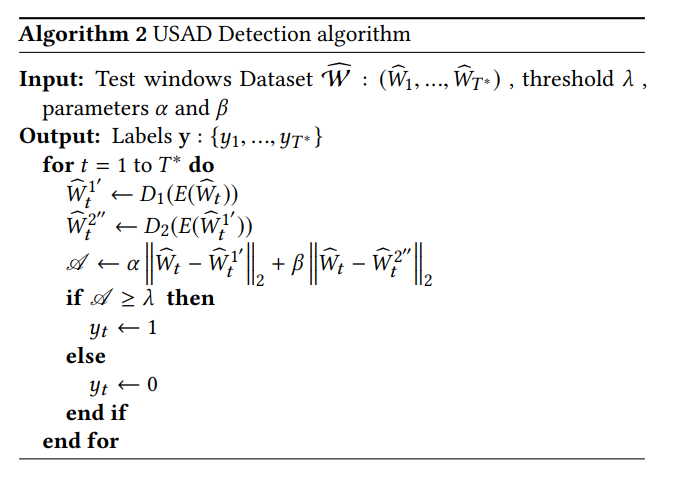

In [12]:
Image('./Data/USAD_a1_pic3.png')

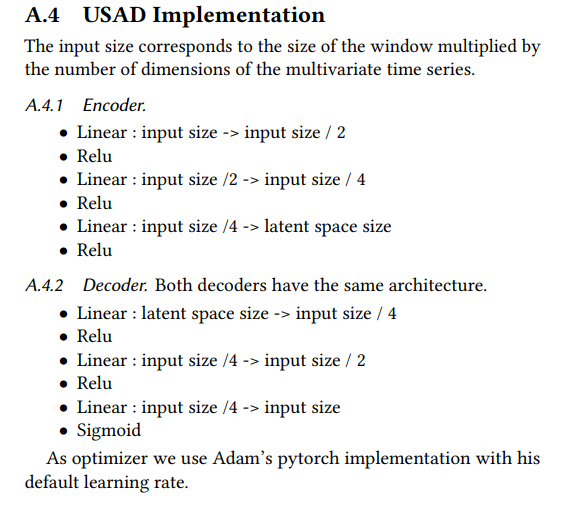

In [13]:
Image('./Data/USAD_a1_pic4.png')

In [14]:
"*"*50

'**************************************************'

## Environment

### Libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

In [16]:
from sklearn.metrics import roc_curve,roc_auc_score

### Functions

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def plot_history(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()
    
def histogram(y_test,y_pred):
    plt.figure(figsize=(12,6))
    plt.hist([y_pred[y_test==0],
              y_pred[y_test==1]],
            bins=20,
            color = ['#82E0AA','#EC7063'],stacked=True)
    plt.title("Results",size=20)
    plt.grid()
    plt.show()
    
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]
    
def confusion_matrix(target, predicted, perc=False):

    data = {'y_Actual':    target,
            'y_Predicted': predicted
            }
    df = pd.DataFrame(data, columns=['y_Predicted','y_Actual'])
    confusion_matrix = pd.crosstab(df['y_Predicted'], df['y_Actual'], rownames=['Predicted'], colnames=['Actual'])
    
    if perc:
        sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
    else:
        sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.show()

In [18]:
device = get_default_device()

In [19]:
class Encoder(nn.Module):
  def __init__(self, in_size, latent_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, int(in_size/2))
    self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
    self.linear3 = nn.Linear(int(in_size/4), latent_size)
    self.relu = nn.ReLU(True)
        
  def forward(self, w):
    out = self.linear1(w)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    z = self.relu(out)
    return z
    
class Decoder(nn.Module):
  def __init__(self, latent_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(latent_size, int(out_size/4))
    self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
    self.linear3 = nn.Linear(int(out_size/2), out_size)
    self.relu = nn.ReLU(True)
    self.sigmoid = nn.Sigmoid()
        
  def forward(self, z):
    out = self.linear1(z)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    w = self.sigmoid(out)
    return w
    
class UsadModel(nn.Module):
  def __init__(self, w_size, z_size):
    super().__init__()
    self.encoder = Encoder(w_size, z_size)
    self.decoder1 = Decoder(z_size, w_size)
    self.decoder2 = Decoder(z_size, w_size)
  
  def training_step(self, batch, n):
    z = self.encoder(batch)
    w1 = self.decoder1(z)
    w2 = self.decoder2(z)
    w3 = self.decoder2(self.encoder(w1))
    loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
    loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return loss1,loss2

  def validation_step(self, batch, n):
    z = self.encoder(batch)
    w1 = self.decoder1(z)
    w2 = self.decoder2(z)
    w3 = self.decoder2(self.encoder(w1))
    loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
    loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return {'val_loss1': loss1, 'val_loss2': loss2}
        
  def validation_epoch_end(self, outputs):
    batch_losses1 = [x['val_loss1'] for x in outputs]
    epoch_loss1 = torch.stack(batch_losses1).mean()
    batch_losses2 = [x['val_loss2'] for x in outputs]
    epoch_loss2 = torch.stack(batch_losses2).mean()
    return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))
    
def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch=to_device(batch,device)
            
            #Train AE1
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()
            
            
            #Train AE2
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()
            
            
        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    
def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

## EDA - Data Pre-Processing

### Download dataset

### Normal period

In [20]:
#Read data
normal = pd.read_excel("./Data/SWaT_Dataset_Normal_v1.xlsx", skiprows=[0])

In [21]:
normal.columns

Index([' Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201',
       'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502',
       'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501',
       'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603',
       'Normal/Attack'],
      dtype='object')

In [22]:
normal = normal.drop([' Timestamp', 'Normal/Attack'] , axis = 1)
normal.shape

(495000, 51)

In [23]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [24]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [25]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [26]:
#Read data
attack = pd.read_excel("./Data/SWaT_Dataset_Attack_v0.xlsx", skiprows=[0])

In [27]:
attack.columns

Index([' Timestamp', 'FIT101', 'LIT101', ' MV101', 'P101', 'P102', ' AIT201',
       'AIT202', 'AIT203', 'FIT201', ' MV201', ' P201', ' P202', 'P203',
       ' P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301',
       'MV302', ' MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402',
       'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501',
       'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504',
       'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602',
       'P603', 'Normal/Attack'],
      dtype='object')

In [28]:
attack['Normal/Attack'].unique()

array(['Normal', 'Attack', 'A ttack'], dtype=object)

In [29]:
labels = [ float(label!= 'Normal' ) for label  in attack['Normal/Attack'].values]
attack = attack.drop([' Timestamp', 'Normal/Attack'], axis = 1)
attack.shape

(449919, 51)

In [30]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [31]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [32]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

In [33]:
window_size=12

In [34]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [35]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [40]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 10
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [41]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0249, val_loss2: 0.0249
Epoch [1], val_loss1: 0.0250, val_loss2: -0.0072
Epoch [2], val_loss1: 0.0215, val_loss2: -0.0102
Epoch [3], val_loss1: 0.0192, val_loss2: -0.0097
Epoch [4], val_loss1: 0.0177, val_loss2: -0.0113
Epoch [5], val_loss1: 0.0192, val_loss2: -0.0135
Epoch [6], val_loss1: 0.0187, val_loss2: -0.0143
Epoch [7], val_loss1: 0.0202, val_loss2: -0.0165
Epoch [8], val_loss1: 0.0470, val_loss2: -0.0389
Epoch [9], val_loss1: 0.0509, val_loss2: -0.0436


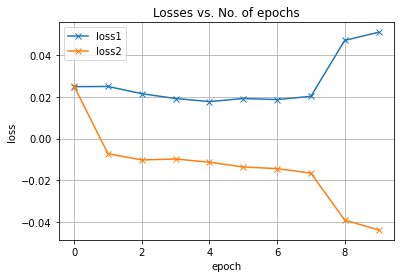

In [42]:
plot_history(history)

In [43]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [44]:
checkpoint = torch.load('model.pth')

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [45]:
results=testing(model,test_loader)

In [46]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [47]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [48]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

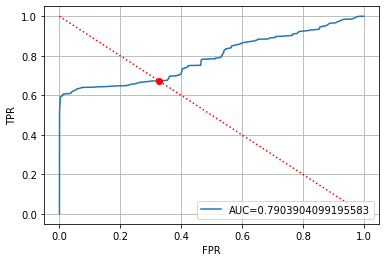

In [49]:
threshold=ROC(y_test,y_pred)